<a href="https://colab.research.google.com/github/Karthikreddy1010/MicroscopicPlastic-Semantic-segmentation/blob/main/Final_microplastic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/archive.zip

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
from scipy import stats
import pandas as pd
from skimage.transform import rotate, resize
import warnings
warnings.filterwarnings('ignore')


# Confirm GPU
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    print(" GPU detected:", gpus)
    # Enable memory growth
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

    # Enable mixed precision
    mixed_precision.set_global_policy('mixed_float16')
    print(" Mixed precision enabled")
else:
    print(" No GPU detected - running on CPU")

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
IMG_HEIGHT = 512
IMG_WIDTH = 512
BATCH_SIZE = 4
EPOCHS = 100
PATIENCE = 15

# Paths to your data
TRAIN_IMAGE_DIR = '/content/training/training/Training_original'
TRAIN_MASK_DIR = '/content/training/training/Finalmasks'
VAL_IMAGE_DIR = '/content/val/val/Original'
VAL_MASK_DIR = '/content/val/val/val_100masks'
TEST_IMAGE_DIR = '/content/Testing/Testing/Original'
TEST_MASK_DIR = '/content/Testing/Testing/testing_100masks'



def normalize_name(name):
    """Normalize filename for matching."""
    name = os.path.basename(name)
    name = os.path.splitext(name)[0]
    name = name.replace('_mask', '')
    return name



def preprocess_mask(mask):
    """Proper mask binarization."""
    mask_binary = (mask > 127).astype(np.float32)
    return mask_binary



def calculate_iou(y_true, y_pred):
    """Calculate Intersection over Union for binary masks."""
    y_true = y_true.flatten().astype(np.uint8)
    y_pred = y_pred.flatten().astype(np.uint8)

    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection

    if union == 0:
        return 0.0

    return intersection / union

def calculate_miou(y_true, y_pred):
    """Calculate mean Intersection over Union for both classes."""
    y_true = y_true.flatten().astype(np.uint8)
    y_pred = y_pred.flatten().astype(np.uint8)

    iou_class_0 = calculate_iou(1 - y_true, 1 - y_pred)  # Background
    iou_class_1 = calculate_iou(y_true, y_pred)           # Foreground

    miou = (iou_class_0 + iou_class_1) / 2.0

    return {
        'iou_background': iou_class_0,
        'iou_foreground': iou_class_1,
        'miou': miou
    }

def calculate_iou_metric(y_true, y_pred):
    """
    Calculate standard IoU (Intersection over Union) metric.

    IoU = Intersection / Union

    Args:
        y_true: Ground truth binary masks (H, W, 1) or (N, H, W, 1)
        y_pred: Predicted binary masks (H, W, 1) or (N, H, W, 1)

    Returns:
        float: IoU score between 0 and 1
    """
    # Flatten arrays and convert to binary
    y_true_flat = y_true.flatten().astype(np.uint8)
    y_pred_flat = y_pred.flatten().astype(np.uint8)

    # Calculate intersection and union
    intersection = np.sum(y_true_flat * y_pred_flat)
    union = np.sum(y_true_flat) + np.sum(y_pred_flat) - intersection

    # Handle edge case where both masks are empty
    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    iou = intersection / union
    return iou

def calculate_iou_per_image(y_true, y_pred):
    """Calculate IoU for each image individually."""
    ious = []
    for i in range(len(y_true)):
        gt = y_true[i].flatten().astype(np.uint8)
        pred = y_pred[i].flatten().astype(np.uint8)

        intersection = np.sum(gt * pred)
        union = np.sum(gt) + np.sum(pred) - intersection

        if union == 0:
            iou = 1.0 if intersection == 0 else 0.0
        else:
            iou = intersection / union
        ious.append(iou)

    return np.array(ious)


def calculate_comprehensive_iou_metrics(y_true, y_pred):
    """Calculate comprehensive IoU metrics including per-class and aggregate stats."""
    y_true_flat = y_true.flatten().astype(np.uint8)
    y_pred_flat = y_pred.flatten().astype(np.uint8)

    # Per-class IoU
    iou_bg = calculate_iou(1 - y_true_flat, 1 - y_pred_flat)
    iou_fg = calculate_iou(y_true_flat, y_pred_flat)
    miou = (iou_bg + iou_fg) / 2.0

    # Standard IoU metric
    iou_standard = calculate_iou_metric(y_true, y_pred)

    # Per-image IoU statistics
    per_image_ious = calculate_iou_per_image(y_true, y_pred)

    return {
        'iou': iou_standard,
        'iou_background': iou_bg,
        'iou_foreground': iou_fg,
        'miou': miou,
        'iou_mean': np.mean(per_image_ious),
        'iou_std': np.std(per_image_ious),
        'iou_median': np.median(per_image_ious),
        'iou_min': np.min(per_image_ious),
        'iou_max': np.max(per_image_ious),
        'per_image_ious': per_image_ious
    }

def calculate_segmentation_metrics(y_true, y_pred_binary):
    """Calculate pixel-wise segmentation metrics."""
    y_true_flat = y_true.flatten().astype(np.uint8)
    y_pred_flat = y_pred_binary.flatten().astype(np.uint8)

    precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)

    intersection = np.sum(y_true_flat * y_pred_flat)
    dice = (2. * intersection) / (np.sum(y_true_flat) + np.sum(y_pred_flat) + 1e-8)

    # Calculate IoU metrics
    iou_metrics = calculate_comprehensive_iou_metrics(y_true, y_pred_binary)

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'dice': dice,
        'iou': iou_metrics['iou'],
        'iou_background': iou_metrics['iou_background'],
        'iou_foreground': iou_metrics['iou_foreground'],
        'miou': iou_metrics['miou'],
        'iou_mean': iou_metrics['iou_mean'],
        'iou_std': iou_metrics['iou_std'],
        'iou_median': iou_metrics['iou_median'],
        'iou_min': iou_metrics['iou_min'],
        'iou_max': iou_metrics['iou_max']
    }


def augment_geometric_numpy(image, mask, seed=None):
    """Apply geometric augmentations (rotation, zoom, flip) with consistent randomness."""
    # Convert TensorFlow tensors to numpy arrays
    if hasattr(image, 'numpy'):
        image = image.numpy()
    if hasattr(mask, 'numpy'):
        mask = mask.numpy()

    # Ensure numpy arrays
    image = np.asarray(image, dtype=np.float32)
    mask = np.asarray(mask, dtype=np.float32)

    if seed is not None:
        np.random.seed(seed)

    h, w = image.shape[:2]

    # Random rotation
    if np.random.rand() < 0.5:
        angle = np.random.uniform(-15, 15)
        image = rotate(image, angle, mode='reflect', preserve_range=True)
        mask = rotate(mask, angle, mode='reflect', preserve_range=True)

    # Random zoom
    if np.random.rand() < 0.5:
        zoom_factor = np.random.uniform(0.9, 1.1)
        new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)

        image_zoomed = resize(image, (new_h, new_w), preserve_range=True, anti_aliasing=True)
        mask_zoomed = resize(mask, (new_h, new_w), preserve_range=True, anti_aliasing=False, order=0)

        # Center crop or pad to original size
        if zoom_factor > 1.0:  # Crop
            start_h = (new_h - h) // 2
            start_w = (new_w - w) // 2
            image = image_zoomed[start_h:start_h+h, start_w:start_w+w]
            mask = mask_zoomed[start_h:start_h+h, start_w:start_w+w]
        else:  # Pad
            pad_h = (h - new_h) // 2
            pad_w = (w - new_w) // 2

            # Handle different mask dimensions
            if len(mask_zoomed.shape) == 3:
                # Mask has channel dimension
                image = np.pad(image_zoomed, ((pad_h, h-new_h-pad_h), (pad_w, w-new_w-pad_w), (0, 0)),
                              mode='reflect')
                mask = np.pad(mask_zoomed, ((pad_h, h-new_h-pad_h), (pad_w, w-new_w-pad_w), (0, 0)),
                             mode='constant', constant_values=0)
            else:
                # Mask is 2D (height, width only)
                image = np.pad(image_zoomed, ((pad_h, h-new_h-pad_h), (pad_w, w-new_w-pad_w), (0, 0)),
                              mode='reflect')
                mask = np.pad(mask_zoomed, ((pad_h, h-new_h-pad_h), (pad_w, w-new_w-pad_w)),
                             mode='constant', constant_values=0)

    # Random horizontal flip
    if np.random.rand() < 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)

    # Random vertical flip
    if np.random.rand() < 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)

    # Ensure mask keeps its original shape
    if len(mask.shape) == 2:
        mask = np.expand_dims(mask, axis=-1)

    return image.astype(np.float32), mask.astype(np.float32)


def augment_photometric_numpy(image, seed=None):
    """Apply photometric augmentations to image only - works on [0, 1] range."""
    # Convert TensorFlow tensor to numpy array
    if hasattr(image, 'numpy'):
        image = image.numpy()

    # Ensure numpy array
    image = np.asarray(image, dtype=np.float32)

    if seed is not None:
        np.random.seed(seed)

    # Random brightness (±0.15)
    brightness = np.random.uniform(-0.05, 0.05)
    image = image + brightness

    # Random contrast (0.85 to 1.15)
    contrast = np.random.uniform(0.95, 1.05)
    mean = image.mean()
    image = (image - mean) * contrast + mean

    # Random gamma (0.85 to 1.15)
    gamma = np.random.uniform(0.95, 1.05)
    image = np.power(np.clip(image, 0, 1), gamma)

    # Very mild Gaussian noise (sigma=0.01)
    noise = np.random.normal(0, 0.005, image.shape).astype(np.float32)
    image = image + noise

    # Clip to valid range [0, 1]
    image = np.clip(image, 0, 1)

    return image.astype(np.float32)


def augment_combined_numpy(image, mask):
    """Combined augmentation pipeline - works on [0, 1] range."""
    # Convert TensorFlow tensors to numpy arrays at the start
    if hasattr(image, 'numpy'):
        image = image.numpy()
    if hasattr(mask, 'numpy'):
        mask = mask.numpy()

    # Ensure numpy arrays
    image = np.asarray(image, dtype=np.float32)
    mask = np.asarray(mask, dtype=np.float32)

    seed = np.random.randint(0, 10000)

    # Geometric augmentations (both)
    image, mask = augment_geometric_numpy(image, mask, seed=seed)

    # Photometric augmentations (image only)
    image = augment_photometric_numpy(image, seed=seed+100)

    return image, mask



def load_data_raw(image_dir, mask_dir):
    """Load RAW data without preprocessing - returns [0, 1] range."""
    print(f"Loading RAW data from: {image_dir}")

    # Check if directory exists
    if not os.path.exists(image_dir):
        raise ValueError(f"Image directory does not exist: {image_dir}")

    if not os.path.exists(mask_dir):
        raise ValueError(f"Mask directory does not exist: {mask_dir}")

    image_paths = sorted([
        os.path.join(image_dir, fname)
        for fname in os.listdir(image_dir)
        if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])

    print(f"Found {len(image_paths)} images")

    images = []
    masks = []

    for img_idx, img_path in enumerate(image_paths):
        fname = os.path.basename(img_path)
        fname_key = normalize_name(fname)

        # Try multiple mask naming patterns
        mask_found = False
        mask_path = None

        # Pattern 1: _mask.png suffix
        mask_candidate = os.path.join(mask_dir, fname_key + '_mask.png')
        if os.path.exists(mask_candidate):
            mask_path = mask_candidate
            mask_found = True

        # Pattern 2: Same name as image
        if not mask_found:
            for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']:
                mask_candidate = os.path.join(mask_dir, fname_key + ext)
                if os.path.exists(mask_candidate):
                    mask_path = mask_candidate
                    mask_found = True
                    break

        # Pattern 3: Original filename
        if not mask_found:
            base_name = os.path.splitext(fname)[0]
            for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']:
                mask_candidate = os.path.join(mask_dir, base_name + ext)
                if os.path.exists(mask_candidate):
                    mask_path = mask_candidate
                    mask_found = True
                    break

        if not mask_found or mask_path is None:
            if img_idx < 5:
                print(f"Warning: No mask found for {fname_key}")
            continue

        try:
            # Load image - keep in [0, 1] range
            img = Image.open(img_path).convert('RGB')
            img = img.resize((IMG_WIDTH, IMG_HEIGHT), Image.BILINEAR)
            img_array = np.array(img, dtype=np.float32) / 255.0

            # Load and preprocess mask
            mask = Image.open(mask_path).convert('L')
            mask = mask.resize((IMG_WIDTH, IMG_HEIGHT), Image.NEAREST)
            mask_array = np.array(mask, dtype=np.float32)
            mask_array = preprocess_mask(mask_array)
            mask_array = np.expand_dims(mask_array, axis=-1)

            images.append(img_array)
            masks.append(mask_array)

            if img_idx < 3:
                print(f"  Loaded: {fname_key} -> shape: {img_array.shape}")

        except Exception as e:
            print(f"Error loading {fname}: {e}")
            continue

    if len(images) == 0:
        raise ValueError(f"No valid images loaded from {image_dir}")

    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)

    print(f"\nSuccessfully loaded {len(images)} images")
    print(f"Image shape: {images.shape}")
    print(f"Image range: [{images.min():.4f}, {images.max():.4f}]")
    print(f"Mask shape: {masks.shape}")

    return images, masks


def create_augmented_dataset_with_preprocessing(images, masks, batch_size, augment=True, shuffle=True):
    """Create tf.data.Dataset with augmentation THEN preprocessing."""

    def preprocess_for_efficientnet(img, mask):
        """Apply EfficientNet preprocessing - converts [0,1] to EfficientNet range."""
        # Convert [0, 1] to [0, 255] then apply EfficientNet preprocessing
        img = img * 255.0
        img = preprocess_input(img)
        return img, mask

    dataset = tf.data.Dataset.from_tensor_slices((images, masks))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images), reshuffle_each_iteration=True)

    # Step 1: Augmentation (if enabled) - works on [0, 1] data
    if augment:
        def augment_fn(img, mask):
            img, mask = tf.py_function(
                func=augment_combined_numpy,
                inp=[img, mask],
                Tout=[tf.float32, tf.float32]
            )
            img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
            mask.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])
            return img, mask

        dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)

    # Step 2: Preprocessing for EfficientNet (AFTER augmentation)
    dataset = dataset.map(preprocess_for_efficientnet, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset



if __name__ == "__main__":
    print("="*80)
    print("LOADING RAW DATA (NO PREPROCESSING YET)")
    print("="*80)

    # Load RAW data - preprocessing will happen in the pipeline
    X_train, y_train = load_data_raw(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR)
    X_val, y_val = load_data_raw(VAL_IMAGE_DIR, VAL_MASK_DIR)
    X_test, y_test = load_data_raw(TEST_IMAGE_DIR, TEST_MASK_DIR)

    print(f"\nData shapes:")
    print(f"Training:   X={X_train.shape}, y={y_train.shape}")
    print(f"Validation: X={X_val.shape}, y={y_val.shape}")
    print(f"Test:       X={X_test.shape}, y={y_test.shape}")



    print("\n" + "="*80)
    print("CREATING DATASETS WITH PREPROCESSING PIPELINE")
    print("="*80)

    # Training dataset: augment THEN preprocess
    train_dataset = create_augmented_dataset_with_preprocessing(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        augment=True,
        shuffle=True
    )

    # Validation dataset: only preprocess (no augmentation)
    val_dataset = create_augmented_dataset_with_preprocessing(
        X_val, y_val,
        batch_size=BATCH_SIZE,
        augment=False,
        shuffle=False
    )

    # Test dataset: only preprocess (no augmentation)
    test_dataset = create_augmented_dataset_with_preprocessing(
        X_test, y_test,
        batch_size=BATCH_SIZE,
        augment=False,
        shuffle=False
    )

    print(" Datasets created successfully:")
    print(f"   Training:   {len(X_train)} samples (augment → preprocess)")
    print(f"   Validation: {len(X_val)} samples (preprocess only)")
    print(f"   Test:       {len(X_test)} samples (preprocess only)")



    print("\n Verifying preprocessing pipeline:")
    for img_batch, mask_batch in train_dataset.take(1):
        print(f"   Batch shape: {img_batch.shape}")
        print(f"   After preprocessing: range=[{img_batch.numpy().min():.4f}, {img_batch.numpy().max():.4f}]")
        print(f"   Mean: {img_batch.numpy().mean():.4f}")

        break

    print("="*80)

# Utility function for model building
def resize_like(x, ref):
    """Resize tensor to match reference shape."""
    return tf.image.resize(x, tf.shape(ref)[1:3], method='bilinear')

 GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
 Mixed precision enabled
LOADING RAW DATA (NO PREPROCESSING YET)
Loading RAW data from: /content/training/training/Training_original
Found 556 images
  Loaded: 100_jpg.rf.f1b9d16649ab385e3691fa54301a3b61 -> shape: (512, 512, 3)
  Loaded: 106_jpg.rf.e8dc04354de3fadaea50922857adf45e -> shape: (512, 512, 3)
  Loaded: 10_jpg.rf.ecfa6fcdfec86c013936528ac959e40d -> shape: (512, 512, 3)

Successfully loaded 556 images
Image shape: (556, 512, 512, 3)
Image range: [0.0000, 1.0000]
Mask shape: (556, 512, 512, 1)
Loading RAW data from: /content/val/val/Original
Found 208 images
  Loaded: a--47-_jpg.rf.4b52f93a6fb94ded6e3a16355ccdf382 -> shape: (512, 512, 3)
  Loaded: a--54-_jpg.rf.0383febe7b193195524f26c0df25ea8c -> shape: (512, 512, 3)
  Loaded: a--56-_jpg.rf.b47891c3c1b3bdf692a27eed2ed119ab -> shape: (512, 512, 3)

Successfully loaded 100 images
Image shape: (100, 512, 512, 3)
Image range: [0.0000, 1.0000]
Mask sh

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.applications import EfficientNetV2B3


def MRFM(x, filters, name):
    """
    Multi-Resolution Fusion Module
    Output channels = filters // 2
    """
    out_ch = filters // 2
    shortcut = x

    # Branch 1: 3x3 convolution
    b3 = layers.Conv2D(filters, 3, padding='same',
                       kernel_initializer='he_normal',
                       name=f'{name}_b3')(x)
    b3 = layers.BatchNormalization(name=f'{name}_b3_bn')(b3)
    b3 = layers.Activation('relu', name=f'{name}_b3_relu')(b3)

    # Branch 2: 5x5 convolution
    b5 = layers.Conv2D(filters, 5, padding='same',
                       kernel_initializer='he_normal',
                       name=f'{name}_b5')(x)
    b5 = layers.BatchNormalization(name=f'{name}_b5_bn')(b5)
    b5 = layers.Activation('relu', name=f'{name}_b5_relu')(b5)

    # Branch 3: Dilated convolution
    bd = layers.Conv2D(filters, 3, dilation_rate=2, padding='same',
                       kernel_initializer='he_normal',
                       name=f'{name}_bd')(x)
    bd = layers.BatchNormalization(name=f'{name}_bd_bn')(bd)
    bd = layers.Activation('relu', name=f'{name}_bd_relu')(bd)

    # Fuse all branches
    fused = layers.Concatenate(name=f'{name}_concat')([b3, b5, bd])
    fused = layers.Conv2D(out_ch, 1, padding='same',
                          kernel_initializer='he_normal',
                          name=f'{name}_compress')(fused)
    fused = layers.BatchNormalization(name=f'{name}_compress_bn')(fused)
    fused = layers.Activation('relu', name=f'{name}_compress_relu')(fused)

    # Residual connection
    if K.int_shape(shortcut)[-1] != out_ch:
        shortcut = layers.Conv2D(out_ch, 1, padding='same',
                                 kernel_initializer='he_normal',
                                 name=f'{name}_shortcut')(shortcut)
        shortcut = layers.BatchNormalization(name=f'{name}_shortcut_bn')(shortcut)

    out = layers.Add(name=f'{name}_add')([fused, shortcut])
    return layers.Activation('relu', name=f'{name}_final_relu')(out)



# EDGE ATTENTION (for early stages - high resolution)

class EdgeAttention(layers.Layer):
    """
    Edge-aware attention for high-resolution early stages.
    Emphasizes boundaries and fine details.
    """
    def __init__(self, channels, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels

    def build(self, input_shape):
        # Sobel-like edge detection filters
        self.edge_conv = layers.Conv2D(
            self.channels, 3, padding='same',
            activation='relu',
            kernel_initializer='he_normal',
            name=f'{self.name}_edge_detector'
        )
        self.attention_conv = layers.Conv2D(
            self.channels, 1, padding='same',
            activation='sigmoid',
            kernel_initializer='glorot_uniform',
            name=f'{self.name}_edge_attention'
        )
        super().build(input_shape)

    def call(self, x):
        # Detect edges
        edges = self.edge_conv(x)

        # Generate attention weights
        attention = self.attention_conv(edges)

        # Apply attention
        return x * attention

    def get_config(self):
        config = super().get_config()
        config.update({'channels': self.channels})
        return config


# COORDINATE ATTENTION (for middle stages)

class CoordinateAttention(layers.Layer):
    """
    Coordinate attention for middle stages.
    Captures spatial dependencies along horizontal and vertical axes.
    """
    def __init__(self, channels, reduction=8, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels
        self.reduction = reduction

    def build(self, input_shape):
        # Reduction layer
        self.conv1 = layers.Conv2D(
            self.channels // self.reduction, 1,
            activation='relu',
            kernel_initializer='he_normal',
            name=f'{self.name}_coord_reduce'
        )

        # Horizontal and vertical projection layers
        self.conv_h = layers.Conv2D(
            self.channels, 1,
            activation='sigmoid',
            kernel_initializer='glorot_uniform',
            name=f'{self.name}_coord_h'
        )
        self.conv_w = layers.Conv2D(
            self.channels, 1,
            activation='sigmoid',
            kernel_initializer='glorot_uniform',
            name=f'{self.name}_coord_w'
        )
        super().build(input_shape)

    def call(self, x):
        # Get dynamic shape
        shape = tf.shape(x)
        batch = shape[0]
        height = shape[1]
        width = shape[2]

        # Pool along height and width
        pool_h = tf.reduce_mean(x, axis=2, keepdims=True)  # [B, H, 1, C]
        pool_w = tf.reduce_mean(x, axis=1, keepdims=True)  # [B, 1, W, C]

        # Combine and process
        pool_w_t = tf.transpose(pool_w, [0, 2, 1, 3])  # [B, W, 1, C]
        concat = tf.concat([pool_h, pool_w_t], axis=1)  # [B, H+W, 1, C]

        # Shared convolution
        concat = self.conv1(concat)

        # Split back
        split_h, split_w = tf.split(concat, [height, width], axis=1)
        split_w = tf.transpose(split_w, [0, 2, 1, 3])

        # Generate attention maps
        att_h = self.conv_h(split_h)
        att_w = self.conv_w(split_w)

        # Apply attention
        return x * att_h * att_w

    def get_config(self):
        config = super().get_config()
        config.update({
            'channels': self.channels,
            'reduction': self.reduction
        })
        return config



# CHANNEL + SPATIAL ATTENTION (for deep stages)

class ChannelSpatialAttention(layers.Layer):
    """
    Combined channel and spatial attention for deep stages.
    Emphasizes important features and regions.
    """
    def __init__(self, channels, reduction=8, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels
        self.reduction = reduction

    def build(self, input_shape):
        # Channel attention
        self.global_avg_pool = layers.GlobalAveragePooling2D(keepdims=False)
        self.global_max_pool = layers.GlobalMaxPooling2D(keepdims=False)

        self.fc1 = layers.Dense(
            self.channels // self.reduction,
            activation='relu',
            kernel_initializer='he_normal',
            name=f'{self.name}_channel_fc1'
        )
        self.fc2 = layers.Dense(
            self.channels,
            activation='sigmoid',
            kernel_initializer='glorot_uniform',
            name=f'{self.name}_channel_fc2'
        )

        # Spatial attention
        self.spatial_conv = layers.Conv2D(
            1, 7, padding='same',
            activation='sigmoid',
            kernel_initializer='glorot_uniform',
            name=f'{self.name}_spatial_attention'
        )
        super().build(input_shape)

    def call(self, x):
        # Channel attention
        avg_pool = self.global_avg_pool(x)
        max_pool = self.global_max_pool(x)

        avg_out = self.fc2(self.fc1(avg_pool))
        max_out = self.fc2(self.fc1(max_pool))

        channel_att = avg_out + max_out
        channel_att = tf.reshape(channel_att, [-1, 1, 1, self.channels])
        x_channel = x * channel_att

        # Spatial attention
        avg_spatial = tf.reduce_mean(x_channel, axis=-1, keepdims=True)
        max_spatial = tf.reduce_max(x_channel, axis=-1, keepdims=True)
        spatial_concat = tf.concat([avg_spatial, max_spatial], axis=-1)

        spatial_att = self.spatial_conv(spatial_concat)
        x_spatial = x_channel * spatial_att

        return x_spatial

    def get_config(self):
        config = super().get_config()
        config.update({
            'channels': self.channels,
            'reduction': self.reduction
        })
        return config



# MICROPLASTIC ATTENTION BLOCK (Stage-Adaptive)

class MicroplasticAttention(layers.Layer):
    """
    Stage-adaptive attention for microplastic segmentation:
    - Early stages (256x256, 128x128): Edge Attention
    - Middle stages (64x64): Coordinate Attention
    - Deep stages (32x32, 16x16): Channel + Spatial Attention
    """
    def __init__(self, channels, stage='early', **kwargs):
        super().__init__(**kwargs)
        self.channels = channels
        self.stage = stage

    def build(self, input_shape):
        if self.stage == 'early':
            self.attention = EdgeAttention(self.channels, name=f'{self.name}_edge')
        elif self.stage == 'middle':
            self.attention = CoordinateAttention(self.channels, name=f'{self.name}_coord')
        elif self.stage == 'deep':
            self.attention = ChannelSpatialAttention(self.channels, name=f'{self.name}_chan_spat')
        else:
            raise ValueError(f"Invalid stage: {self.stage}. Must be 'early', 'middle', or 'deep'")

        super().build(input_shape)

    def call(self, x):
        return self.attention(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            'channels': self.channels,
            'stage': self.stage
        })
        return config



# FINAL MODEL BUILDER — 512×512 OUTPUT

def build_efficientnetv2b3_mrfm_attention_unet(input_shape=(512, 512, 3)):
    """
    Build EfficientNetV2B3-based U-Net with MRFM and stage-adaptive attention.
    Output shape: (batch_size, 512, 512, 1)
    """
    inputs = layers.Input(shape=input_shape, name='input_image')

    # Backbone encoder (trainable)
    backbone = EfficientNetV2B3(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs
    )
    backbone.trainable = True

    print(f" Backbone trainable: {backbone.trainable}")
    print(f" Total backbone layers: {len(backbone.layers)}")

    # Extract encoder features with error handling
    try:
        e1 = backbone.get_layer('block1b_add').output      # ~256x256
        e2 = backbone.get_layer('block2b_add').output      # ~128x128
        e3 = backbone.get_layer('block3b_add').output      # ~64x64
        e4 = backbone.get_layer('block5c_add').output      # ~32x32
        e5 = backbone.get_layer('top_activation').output   # ~16x16
        print(" Successfully extracted all encoder features")
    except Exception as e:
        print(f" Error extracting encoder features: {e}")
        print("Available layer names:")
        for layer in backbone.layers:
            if 'block' in layer.name or 'top' in layer.name:
                print(f"  - {layer.name}: {layer.output_shape}")
        raise

    # Get actual channel counts from encoder features
    e1_channels = K.int_shape(e1)[-1]
    e2_channels = K.int_shape(e2)[-1]
    e3_channels = K.int_shape(e3)[-1]
    e4_channels = K.int_shape(e4)[-1]
    e5_channels = K.int_shape(e5)[-1]

    print(f"\n Encoder feature channels:")
    print(f"  e1: {e1_channels}, e2: {e2_channels}, e3: {e3_channels}, e4: {e4_channels}, e5: {e5_channels}")

    # Encoder with MRFM and attention
    e1_processed = MRFM(e1, 64, 'mrfm1')  # Output: 32 channels
    e1_processed = MicroplasticAttention(32, stage='early', name='enc1_attn')(e1_processed)

    e2_processed = MRFM(e2, 128, 'mrfm2')  # Output: 64 channels
    e2_processed = MicroplasticAttention(64, stage='early', name='enc2_attn')(e2_processed)

    e3_processed = MRFM(e3, 256, 'mrfm3')  # Output: 128 channels
    e3_processed = MicroplasticAttention(128, stage='middle', name='enc3_attn')(e3_processed)

    e4_processed = MRFM(e4, 512, 'mrfm4')  # Output: 256 channels
    e4_processed = MicroplasticAttention(256, stage='deep', name='enc4_attn')(e4_processed)

    e5_processed = MRFM(e5, 512, 'mrfm5')  # Output: 256 channels
    e5_processed = MicroplasticAttention(256, stage='deep', name='enc5_attn')(e5_processed)

    # Decoder with skip connections
    d4 = layers.Conv2DTranspose(256, 2, strides=2, padding='same',
                                kernel_initializer='he_normal',
                                name='up4')(e5_processed)
    d4 = layers.Concatenate(name='concat4')([d4, e4_processed])
    d4 = MRFM(d4, 512, 'dec4')
    d4 = MicroplasticAttention(256, stage='deep', name='dec4_attn')(d4)

    d3 = layers.Conv2DTranspose(128, 2, strides=2, padding='same',
                                kernel_initializer='he_normal',
                                name='up3')(d4)
    d3 = layers.Concatenate(name='concat3')([d3, e3_processed])
    d3 = MRFM(d3, 256, 'dec3')
    d3 = MicroplasticAttention(128, stage='middle', name='dec3_attn')(d3)

    d2 = layers.Conv2DTranspose(64, 2, strides=2, padding='same',
                                kernel_initializer='he_normal',
                                name='up2')(d3)
    d2 = layers.Concatenate(name='concat2')([d2, e2_processed])
    d2 = MRFM(d2, 128, 'dec2')
    d2 = MicroplasticAttention(64, stage='early', name='dec2_attn')(d2)

    d1 = layers.Conv2DTranspose(32, 2, strides=2, padding='same',
                                kernel_initializer='he_normal',
                                name='up1')(d2)
    d1 = layers.Concatenate(name='concat1')([d1, e1_processed])
    d1 = MRFM(d1, 64, 'dec1')
    d1 = MicroplasticAttention(32, stage='early', name='dec1_attn')(d1)

    # Final upsampling to 512x512
    d0 = layers.Conv2DTranspose(16, 2, strides=2, padding='same',
                                kernel_initializer='he_normal',
                                name='up0')(d1)
    d0 = layers.Conv2D(32, 3, padding='same', activation='relu',
                       kernel_initializer='he_normal',
                       name='final_conv1')(d0)
    d0 = layers.Conv2D(16, 3, padding='same', activation='relu',
                       kernel_initializer='he_normal',
                       name='final_conv2')(d0)

    # Output layer - keep as (B, H, W, 1) for proper gradient flow
    outputs = layers.Conv2D(
        1, 1, activation='sigmoid',
        dtype='float32',  # Force float32 for mixed precision compatibility
        kernel_initializer='glorot_uniform',
        name='segmentation_output'
    )(d0)

    # Create model
    model = models.Model(
        inputs, outputs,
        name='EfficientNetV2B3_MRFM_MicroplasticAttention_UNet'
    )

    print(f"\n Model created successfully!")
    print(f"   Input shape:  {model.input_shape}")
    print(f"   Output shape: {model.output_shape}")
    print(f"   Total params: {model.count_params():,}")

    return model, backbone




Class weights - Background: 0.5228, Foreground: 11.4485
 Loss functions defined

BUILDING MODEL
52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
 Backbone trainable: True
 Total backbone layers: 409
 Successfully extracted all encoder features

 Encoder feature channels:
  e1: 16, e2: 40, e3: 56, e4: 136, e5: 1536

 Model created successfully!
   Input shape:  (None, 512, 512, 3)
   Output shape: (None, 512, 512, 1)
   Total params: 68,303,512
 Model built successfully
   Total parameters: 68,303,512
   Output shape: (None, 512, 512, 1)

PHASE 1: Training decoder (backbone frozen)

Training Phase 1 with 556 samples
Epoch 1/40
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - dice_coefficient: 0.4313 - iou_metric: 0.3077 - loss: 4.5248
   [Epoch 0] Predictions: max=1.0000, mean=0.1355, fg_pixels=138,479/1,048,576 (13.206%)

Epoch 1: val_dice_coefficient improved from -inf to 0.27152, saving model to /content/efficientnetv2b3_mrfm_attention_phase1.weights.h5
139/139 ━━━━━━━━━━━━━━━━━━━━ 284

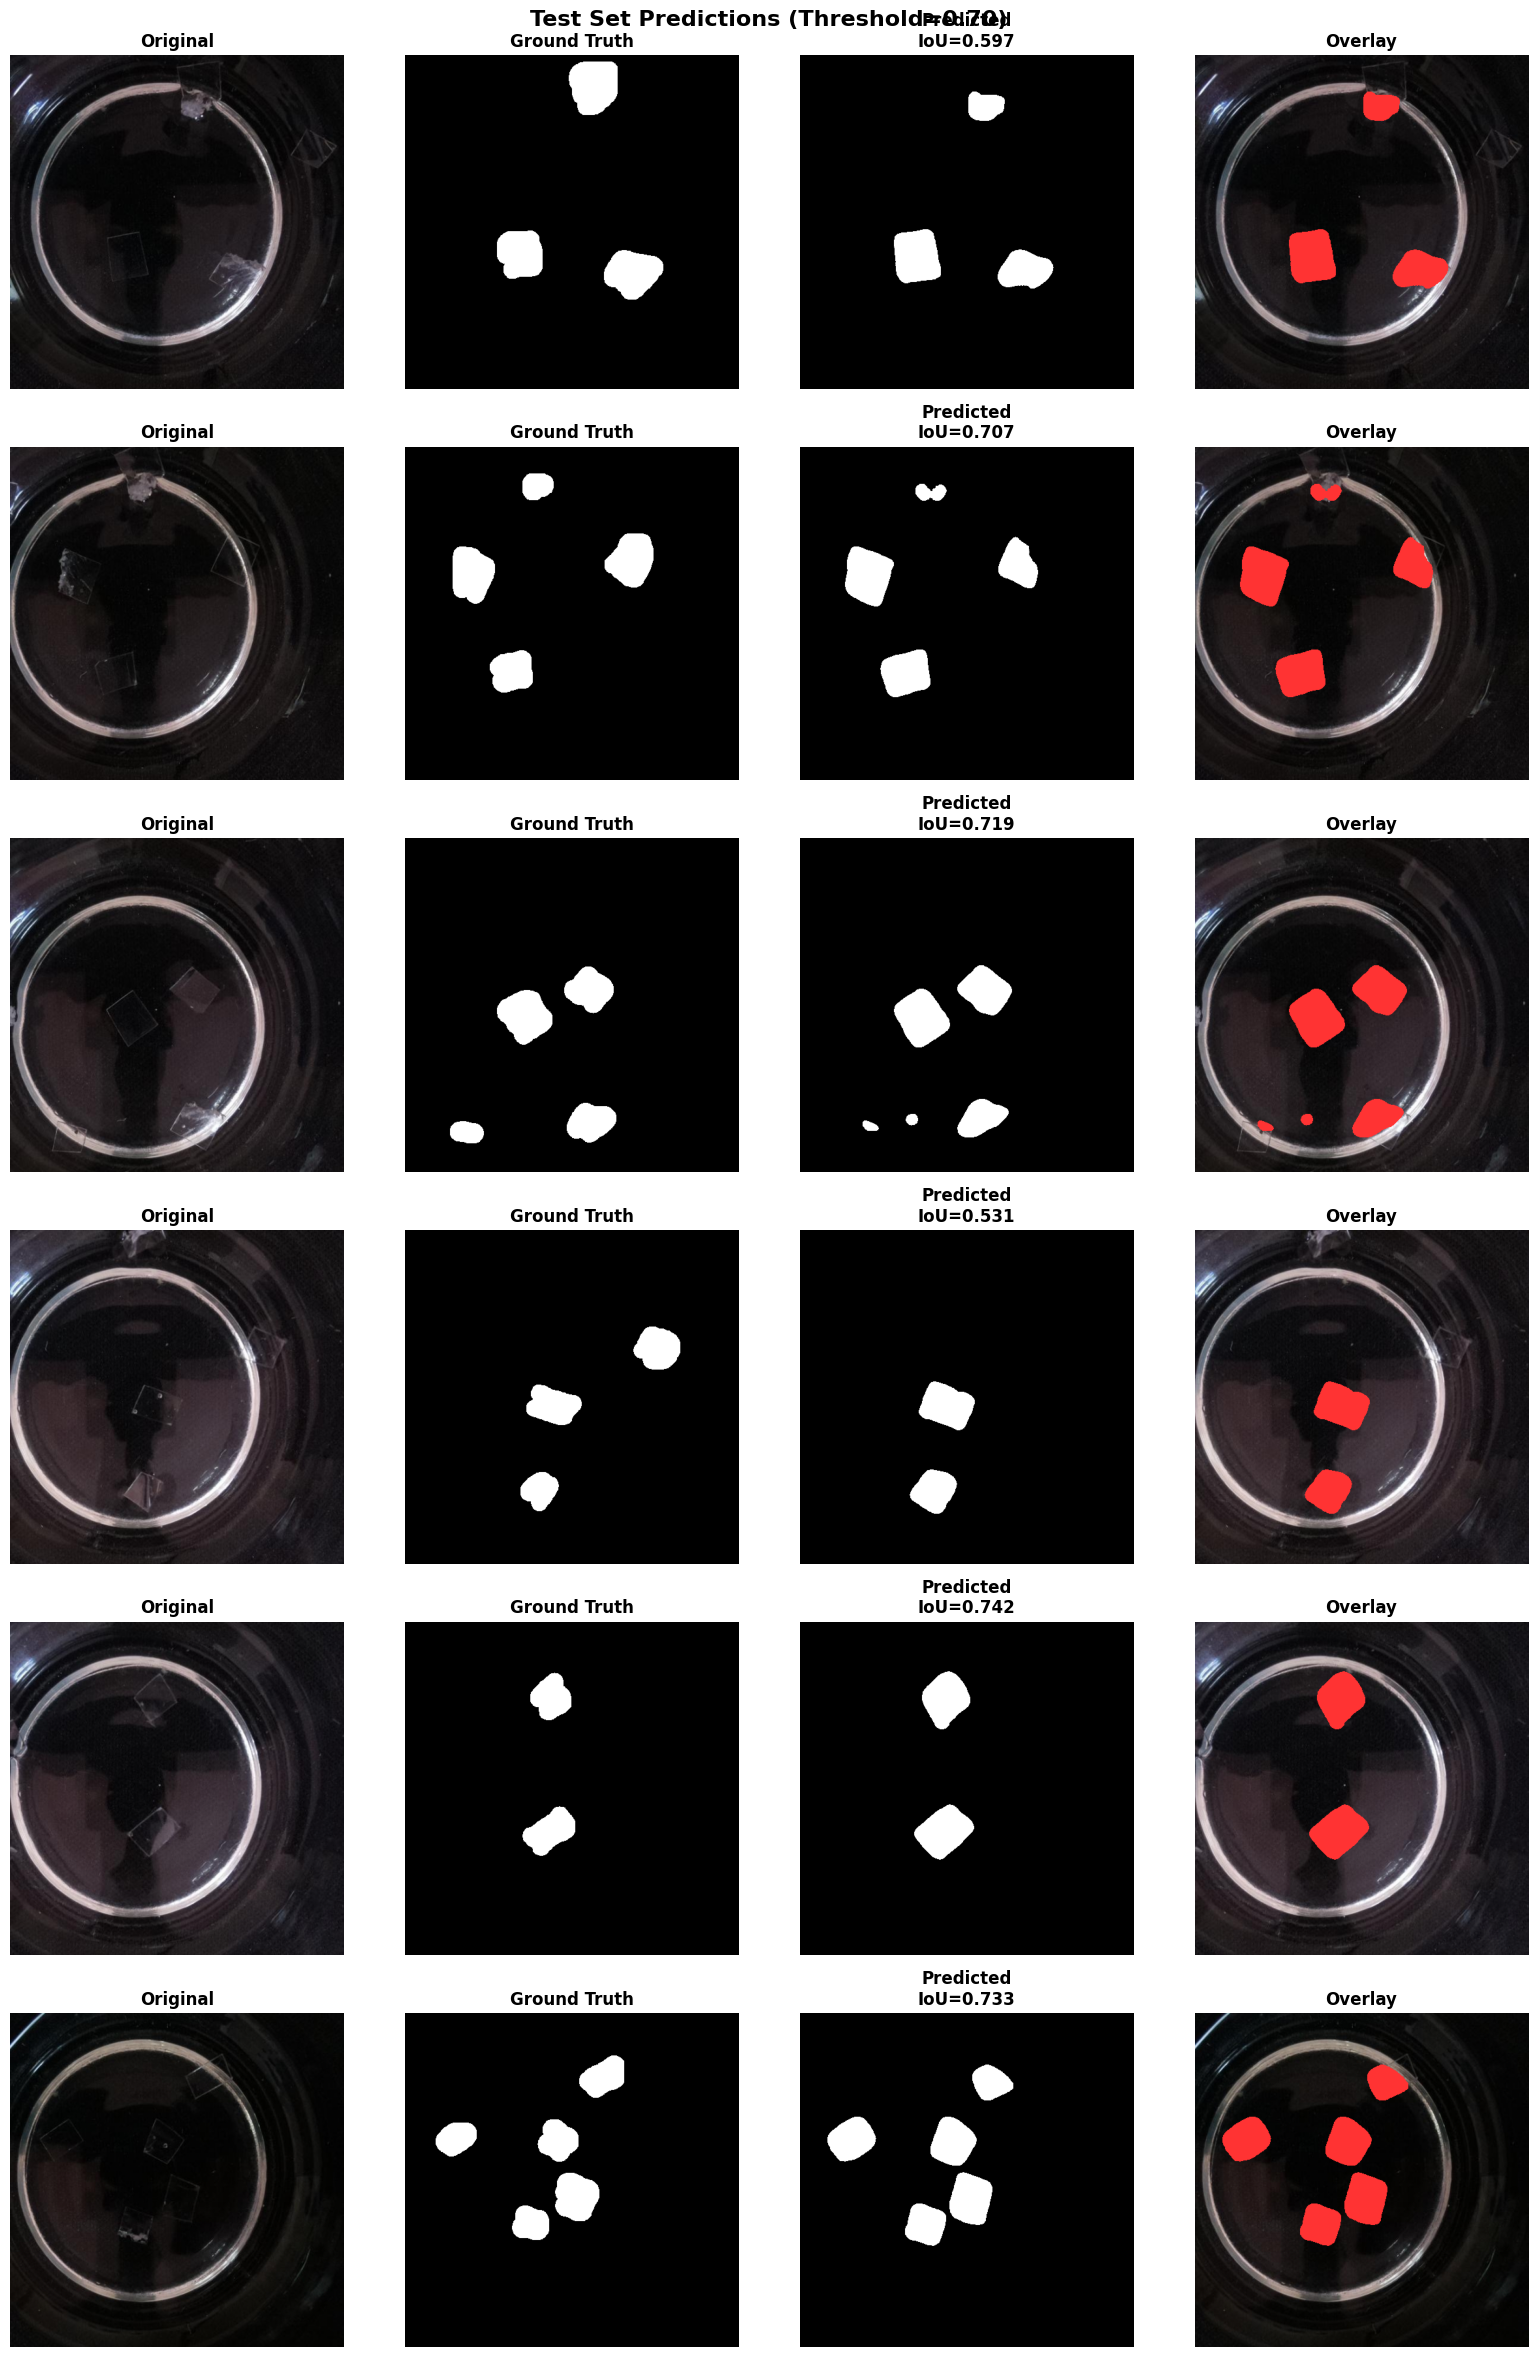

 Visualizations saved


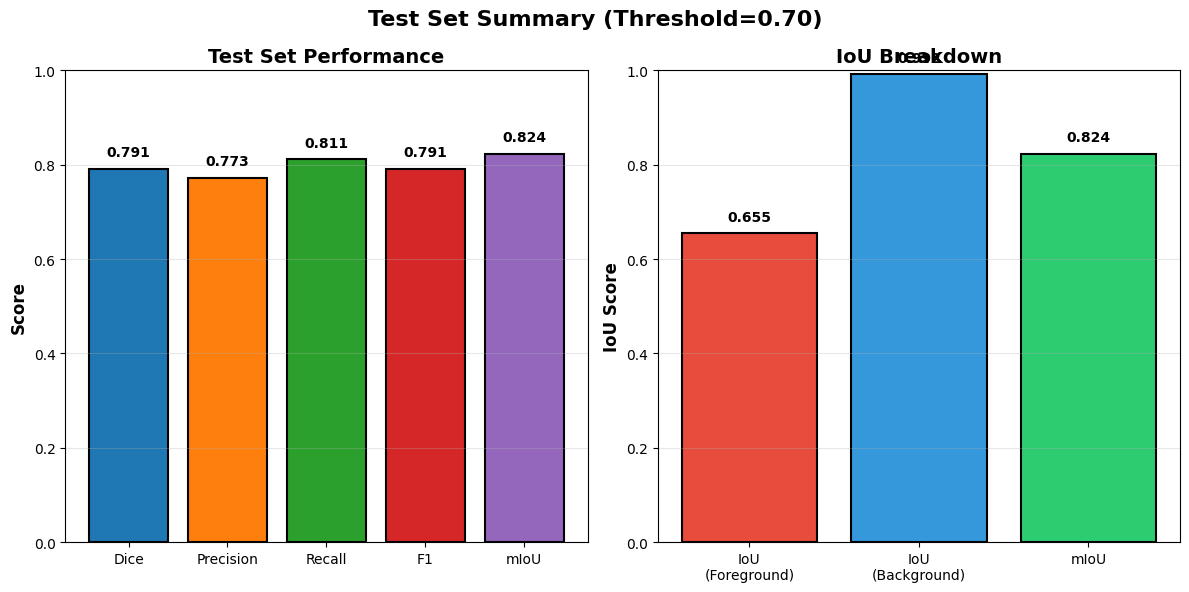

 Performance summary saved

 Report saved to 'results_efficientnetv2b3_mrfm_attention_512/test_report.txt'
 TEST EVALUATION COMPLETE!


In [5]:

# CUSTOM LOSS FUNCTIONS - OPTIMIZED FOR SEVERE IMBALANCE


from sklearn.utils.class_weight import compute_class_weight

def calculate_class_weights(masks):
    """Calculate class weights for imbalanced segmentation."""
    masks_flat = (masks > 0.5).astype(np.uint8).flatten()
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=masks_flat
    )
    return {0: class_weights[0], 1: class_weights[1]}

if len(y_train) > 0:
    class_weights = calculate_class_weights(y_train)
    cw0 = tf.constant(class_weights[0], dtype=tf.float32)
    cw1 = tf.constant(class_weights[1], dtype=tf.float32)
    print(f"Class weights - Background: {cw0:.4f}, Foreground: {cw1:.4f}")
else:
    cw0 = tf.constant(1.0, dtype=tf.float32)
    cw1 = tf.constant(1.0, dtype=tf.float32)
    print(" No training data - using default weights")


def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Dice coefficient metric."""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)
    return (2.0 * intersection + smooth) / (union + smooth)


def dice_loss(y_true, y_pred, smooth=1e-6):
    """Dice loss."""
    return 1.0 - dice_coefficient(y_true, y_pred, smooth)


def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """Focal loss for class imbalance."""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    y_pred_flat = tf.clip_by_value(y_pred_flat, K.epsilon(), 1 - K.epsilon())

    pt = tf.where(tf.equal(y_true_flat, 1), y_pred_flat, 1 - y_pred_flat)
    alpha_t = tf.where(tf.equal(y_true_flat, 1), alpha, 1 - alpha)
    loss = -alpha_t * tf.pow(1 - pt, gamma) * tf.math.log(pt)
    return tf.reduce_mean(loss)

def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1e-6):
    """Tversky loss - emphasizes recall."""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    true_pos = tf.reduce_sum(y_true_flat * y_pred_flat)
    false_neg = tf.reduce_sum(y_true_flat * (1 - y_pred_flat))
    false_pos = tf.reduce_sum((1 - y_true_flat) * y_pred_flat)

    tversky = (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)
    return 1.0 - tversky


def aggressive_imbalance_loss(y_true, y_pred):
    """Combined loss for severe class imbalance."""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())

    dice = dice_loss(y_true, y_pred)
    tversky = tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3)
    focal = focal_loss(y_true, y_pred, alpha=0.75, gamma=2.0)

    total_loss = 5.0 * dice + 3.0 * tversky + 1.0 * focal
    return total_loss

def focal_dice_loss(y_true, y_pred, gamma=2.0, dice_weight=3.0, focal_weight=1.0):
    """Combined focal and dice loss."""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    focal = focal_loss(y_true, y_pred, alpha=0.75, gamma=gamma)
    dice = dice_loss(y_true, y_pred)
    return focal_weight * focal + dice_weight * dice

def iou_metric(y_true, y_pred, smooth=1e-6):
    """IoU metric."""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def dice_numpy(y_true, y_pred, smooth=1e-6):
    """Dice coefficient for numpy arrays (for threshold tuning)."""
    y_true = y_true.astype(np.float32).flatten()
    y_pred = y_pred.astype(np.float32).flatten()
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def calculate_iou(y_true, y_pred):
    """Calculate Intersection over Union for numpy arrays."""
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / union if union > 0 else 0

print(" Loss functions defined")




class PredictionMonitor(tf.keras.callbacks.Callback):
    """Monitor predictions during training."""
    def __init__(self, val_data, val_masks):
        super().__init__()
        self.val_data_raw = val_data[:4]
        self.val_masks = val_masks[:4]
        self.val_data = preprocess_input(self.val_data_raw * 255.0)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 3 == 0:
            preds = self.model.predict(self.val_data, verbose=0)
            preds_flat = preds.flatten()
            fg_pixels = (preds_flat > 0.5).sum()
            total_pixels = preds_flat.size
            max_pred = preds_flat.max()
            mean_pred = preds_flat.mean()
            print(f"\n   [Epoch {epoch}] Predictions: max={max_pred:.4f}, mean={mean_pred:.4f}, "
                  f"fg_pixels={fg_pixels:,}/{total_pixels:,} ({fg_pixels/total_pixels*100:.3f}%)")




def preprocess_test_data(X_test):
    """Preprocess test data the same way as training data."""
    X_test_preprocessed = preprocess_input(X_test * 255.0)
    return X_test_preprocessed



print("\n" + "="*80)
print("BUILDING MODEL")
print("="*80)

model, backbone = build_efficientnetv2b3_mrfm_attention_unet(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

print(f" Model built successfully")
print(f"   Total parameters: {model.count_params():,}")
print(f"   Output shape: {model.output.shape}")



print("\n" + "="*80)
print("PHASE 1: Training decoder (backbone frozen)")
print("="*80)

backbone.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=aggressive_imbalance_loss,
    metrics=[dice_coefficient, iou_metric]
)

callbacks_phase1 = [
    PredictionMonitor(X_val, y_val),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_dice_coefficient',
        patience=15,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_dice_coefficient',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        '/content/efficientnetv2b3_mrfm_attention_phase1.weights.h5',
        monitor='val_dice_coefficient',
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        verbose=1
    )
]

print(f"\nTraining Phase 1 with {len(X_train)} samples")
history_phase1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    callbacks=callbacks_phase1,
    verbose=1
)

print(f"\n Phase 1 complete - Best Dice: {max(history_phase1.history['val_dice_coefficient']):.4f}")


print("\n" + "="*80)
print("PHASE 2: Fine-tuning entire model")
print("="*80)

backbone.trainable = True
for layer in backbone.layers[:-80]:
    layer.trainable = False

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

optimizer_ft = tf.keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=1e-5,
    beta_1=0.9,
    beta_2=0.999
)

model.compile(
    optimizer=optimizer_ft,
    loss=focal_dice_loss,
    metrics=[
        dice_coefficient,
        iou_metric,
        'binary_accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

callbacks_phase2 = [
    PredictionMonitor(X_val, y_val),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_dice_coefficient',
        patience=PATIENCE,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_dice_coefficient',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        '/content/efficientnetv2b3_mrfm_attention_final.weights.h5',
        monitor='val_dice_coefficient',
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        verbose=1
    )
]

print(f"\nTraining Phase 2 with {len(X_train)} samples")
history_phase2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks_phase2,
    verbose=1,
    initial_epoch=len(history_phase1.history['loss'])
)

print("\n Two-phase training complete!")
print(f"   Best Dice (Phase 2): {max(history_phase2.history['val_dice_coefficient']):.4f}")

print("\n" + "="*80)
print("TRAINING COMPLETE - MODEL READY FOR EVALUATION")
print("="*80)




print("\n" + "="*80)
print("LOADING BEST MODEL")
print("="*80)

# Reconstruct model architecture
print("Reconstructing model architecture...")
model, backbone = build_efficientnetv2b3_mrfm_attention_unet(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

backbone.trainable = True
for layer in backbone.layers[:-80]:
    layer.trainable = False

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

optimizer_ft = tf.keras.optimizers.AdamW(
    learning_rate=5e-5,
    weight_decay=1e-5,
    beta_1=0.9,
    beta_2=0.999
)

model.compile(
    optimizer=optimizer_ft,
    loss=focal_dice_loss,
    metrics=[
        dice_coefficient,
        iou_metric,
        'binary_accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Load best weights
print("Loading best weights...")
model.load_weights('/content/efficientnetv2b3_mrfm_attention_final.weights.h5')
print(" Model weights loaded successfully")




print("\n" + "="*80)
print(" TUNING SEGMENTATION THRESHOLD ON VALIDATION SET")
print("="*80)

# Preprocess validation data
X_val_preprocessed = preprocess_test_data(X_val)

# Generate raw validation predictions
print("Generating raw validation predictions...")
y_val_pred_soft = model.predict(
    X_val_preprocessed,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Tune threshold
thresholds = np.linspace(0.1, 0.7, 13)
best_t, best_dice = 0, 0

print("\nThreshold tuning results:")
print("-" * 40)

for t in thresholds:
    y_val_pred_bin = (y_val_pred_soft > t).astype(np.uint8)
    dice = dice_numpy(y_val, y_val_pred_bin)

    print(f"  Threshold={t:.2f} → Dice={dice:.4f}")

    if dice > best_dice:
        best_dice = dice
        best_t = t

print("-" * 40)
print(f" Best threshold: {best_t:.2f}")
print(f" Best Dice on validation: {best_dice:.4f}")

# Lock the threshold
SEG_THRESHOLD = best_t
print(f" Locked threshold at {SEG_THRESHOLD:.2f}")
print("="*80)


def diagnose_test_data(X_test, y_test, test_image_dir, test_mask_dir):
    """Diagnose potential issues with test data loading."""
    print("\n" + "="*80)
    print("DIAGNOSTIC: TEST DATA VERIFICATION")
    print("="*80)

    print(f"\n1️ Test Images:")
    print(f"   Directory: {test_image_dir}")
    print(f"   Loaded shape: {X_test.shape}")
    print(f"   Value range: [{X_test.min():.4f}, {X_test.max():.4f}]")

    print(f"\n2️ Test Masks:")
    print(f"   Directory: {test_mask_dir}")
    print(f"   Loaded shape: {y_test.shape}")
    print(f"   Unique values: {np.unique(y_test)}")
    print(f"   Positive pixels: {(y_test > 0.5).sum() / y_test.size * 100:.2f}%")

    print(f"\n3️ File Matching:")
    image_files = sorted([f for f in os.listdir(test_image_dir)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    mask_files = sorted([f for f in os.listdir(test_mask_dir)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    print(f"   Image files: {len(image_files)}")
    print(f"   Mask files: {len(mask_files)}")
    print(f"   Loaded pairs: {len(X_test)}")

    if len(image_files) != len(X_test):
        print(f"    WARNING: Missing {len(image_files) - len(X_test)} pairs")

    print("="*80)


def evaluate_test_set_corrected(model, X_test, y_test, threshold, batch_size=4):
    """Properly evaluate test set with correct ground truth handling."""
    print("\n" + "="*80)
    print(f"EVALUATING TEST SET (Threshold={threshold:.2f})")
    print("="*80)

    # Verify data
    print(f"\n Test data verification:")
    print(f"   X_test shape: {X_test.shape}, range: [{X_test.min():.4f}, {X_test.max():.4f}]")
    print(f"   y_test shape: {y_test.shape}, unique: {np.unique(y_test)}")

    # Preprocess
    print(f"\n Preprocessing...")
    X_test_preprocessed = preprocess_input(X_test * 255.0)
    print(f"   After preprocessing: [{X_test_preprocessed.min():.2f}, {X_test_preprocessed.max():.2f}]")

    # Predict
    print(f"\n Generating predictions...")
    y_pred_raw = model.predict(X_test_preprocessed, batch_size=batch_size, verbose=1)
    print(f"   Predictions: [{y_pred_raw.min():.4f}, {y_pred_raw.max():.4f}], mean={y_pred_raw.mean():.4f}")

    # Binarize
    y_pred_binary = (y_pred_raw > threshold).astype(np.uint8)
    y_test_binary = (y_test > 0.5).astype(np.uint8)

    # Ensure shape match
    if y_test_binary.shape != y_pred_binary.shape:
        print(f"    Reshaping to match...")
        if len(y_test_binary.shape) == 3:
            y_test_binary = np.expand_dims(y_test_binary, axis=-1)
        if len(y_pred_binary.shape) == 3:
            y_pred_binary = np.expand_dims(y_pred_binary, axis=-1)

    # Calculate metrics
    print(f"\n Calculating metrics...")
    y_true_flat = y_test_binary.flatten().astype(np.uint8)
    y_pred_flat = y_pred_binary.flatten().astype(np.uint8)

    print(f"   GT positive: {y_true_flat.sum():,} ({y_true_flat.sum()/len(y_true_flat)*100:.2f}%)")
    print(f"   Pred positive: {y_pred_flat.sum():,} ({y_pred_flat.sum()/len(y_pred_flat)*100:.2f}%)")

    seg_metrics = calculate_segmentation_metrics(y_test_binary, y_pred_binary)

    # Print results
    print(f"\n{'='*60}")
    print(f"TEST SET RESULTS (Threshold={threshold:.2f})")
    print(f"{'='*60}")
    print(f"{'Metric':<25} {'Value':<10}")
    print(f"{'-'*60}")
    print(f"{'Dice Coefficient':<25} {seg_metrics['dice']:.4f}")
    print(f"{'Precision':<25} {seg_metrics['precision']:.4f}")
    print(f"{'Recall':<25} {seg_metrics['recall']:.4f}")
    print(f"{'F1-Score':<25} {seg_metrics['f1']:.4f}")
    print(f"{'mIoU':<25} {seg_metrics['miou']:.4f}")
    print(f"{'IoU (Foreground)':<25} {seg_metrics['iou_foreground']:.4f}")
    print(f"{'IoU (Background)':<25} {seg_metrics['iou_background']:.4f}")
    print(f"{'='*60}")

    return {
        'segmentation_metrics': seg_metrics,
        'predictions_raw': y_pred_raw,
        'predictions_binary': y_pred_binary,
        'ground_truth': y_test_binary
    }




# Step 1: Diagnose
diagnose_test_data(X_test, y_test, TEST_IMAGE_DIR, TEST_MASK_DIR)

# Step 2: Evaluate
test_results = evaluate_test_set_corrected(
    model, X_test, y_test,
    threshold=SEG_THRESHOLD,
    batch_size=BATCH_SIZE
)

seg_metrics = test_results['segmentation_metrics']




# Create results directory
os.makedirs('results_efficientnetv2b3_mrfm_attention_512', exist_ok=True)

print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# Sample predictions
num_samples = min(6, len(X_test))
fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
if num_samples == 1:
    axes = axes.reshape(1, -1)

for idx in range(num_samples):
    img_display = np.clip(X_test[idx], 0, 1)
    gt_mask = test_results['ground_truth'][idx].squeeze()
    pred_mask = test_results['predictions_binary'][idx].squeeze()

    axes[idx, 0].imshow(img_display)
    axes[idx, 0].set_title('Original', fontweight='bold')
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(gt_mask, cmap='gray')
    axes[idx, 1].set_title('Ground Truth', fontweight='bold')
    axes[idx, 1].axis('off')

    iou = calculate_iou(gt_mask.flatten(), pred_mask.flatten())
    axes[idx, 2].imshow(pred_mask, cmap='gray')
    axes[idx, 2].set_title(f'Predicted\nIoU={iou:.3f}', fontweight='bold')
    axes[idx, 2].axis('off')

    overlay = img_display.copy()
    if len(overlay.shape) == 2:
        overlay = np.stack([overlay]*3, axis=-1)
    overlay[pred_mask > 0.5] = [1.0, 0.2, 0.2]
    axes[idx, 3].imshow(overlay)
    axes[idx, 3].set_title('Overlay', fontweight='bold')
    axes[idx, 3].axis('off')

plt.suptitle(f'Test Set Predictions (Threshold={SEG_THRESHOLD:.2f})',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('results_efficientnetv2b3_mrfm_attention_512/test_predictions.png',
            dpi=300, bbox_inches='tight')
plt.show()
print(" Visualizations saved")




fig = plt.figure(figsize=(12, 6))

# Metrics bar chart
ax1 = plt.subplot(1, 2, 1)
metrics_names = ['Dice', 'Precision', 'Recall', 'F1', 'mIoU']
metrics_values = [seg_metrics['dice'], seg_metrics['precision'],
                  seg_metrics['recall'], seg_metrics['f1'], seg_metrics['miou']]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars = ax1.bar(metrics_names, metrics_values, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Test Set Performance', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 1.0)
ax1.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.02,
             f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# IoU breakdown
ax2 = plt.subplot(1, 2, 2)
iou_names = ['IoU\n(Foreground)', 'IoU\n(Background)', 'mIoU']
iou_values = [seg_metrics['iou_foreground'], seg_metrics['iou_background'], seg_metrics['miou']]
colors2 = ['#e74c3c', '#3498db', '#2ecc71']
bars2 = ax2.bar(iou_names, iou_values, color=colors2, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('IoU Score', fontsize=12, fontweight='bold')
ax2.set_title('IoU Breakdown', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1.0)
ax2.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars2, iou_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.02,
             f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle(f'Test Set Summary (Threshold={SEG_THRESHOLD:.2f})', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('results_efficientnetv2b3_mrfm_attention_512/performance_summary.png',
            dpi=300, bbox_inches='tight')
plt.show()
print(" Performance summary saved")




report_path = 'results_efficientnetv2b3_mrfm_attention_512/test_report.txt'
with open(report_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write("MICROPLASTIC DETECTION - TEST SET RESULTS\n")
    f.write("="*80 + "\n\n")

    f.write("THRESHOLD TUNING\n")
    f.write("-" * 40 + "\n")
    f.write(f"  Optimized on validation set: {SEG_THRESHOLD:.2f}\n")
    f.write(f"  Validation Dice: {best_dice:.4f}\n\n")

    f.write("TEST SET PERFORMANCE\n")
    f.write("-" * 40 + "\n")
    f.write(f"  Dice = {seg_metrics['dice']:.4f}\n")
    f.write(f"  Precision = {seg_metrics['precision']:.4f}\n")
    f.write(f"  Recall = {seg_metrics['recall']:.4f}\n")
    f.write(f"  F1 = {seg_metrics['f1']:.4f}\n")
    f.write(f"  mIoU = {seg_metrics['miou']:.4f}\n")
    f.write(f"  IoU (Foreground) = {seg_metrics['iou_foreground']:.4f}\n")
    f.write(f"  IoU (Background) = {seg_metrics['iou_background']:.4f}\n\n")
    f.write("="*80 + "\n")

print(f"\n Report saved to '{report_path}'")
print("="*80)
print(" TEST EVALUATION COMPLETE!")